In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully!")
print("V2: Feature Engineering Experiment")
print("Goal: Create new features to boost Stage 1 performance")

Libraries loaded successfully!
V2: Feature Engineering Experiment
Goal: Create new features to boost Stage 1 performance


In [3]:
df = pd.read_csv('../data/Exoplanet_Dataset.csv')

print("="*80)
print("V2 - STAGE 1 FEATURE ENGINEERING")
print("="*80)

original_features = ['radius', 'orbital_period', 'star_mass']
target = 'mass'

required_cols = original_features + [target]
df_stage1 = df[required_cols].dropna()

print(f"\nDataset loaded: {len(df)} rows")
print(f"Stage 1 available data: {len(df_stage1)} rows")

print("\nBASELINE REMINDER:")
print(" MVP (Original features):     R² = 0.0755")
print(" V2 Log Transform:            R² = 0.1124 (1.5x better)")
print("\nTARGET: R² > 0.40 with feature engineering")

print("\nOriginal Features:")
for i, feat in enumerate(original_features, 1):
    print(f"  {i}. {feat}")

V2 - STAGE 1 FEATURE ENGINEERING

Dataset loaded: 5986 rows
Stage 1 available data: 1521 rows

BASELINE REMINDER:
 MVP (Original features):     R² = 0.0755
 V2 Log Transform:            R² = 0.1124 (1.5x better)

TARGET: R² > 0.40 with feature engineering

Original Features:
  1. radius
  2. orbital_period
  3. star_mass


In [6]:
print("="*80)
print("CREATING NEW FEATURES")
print("="*80)

# Create a copy to work with
df_engineered = df_stage1.copy()


# ============================================================================
# FEATURE 1: ORBITAL VELOCITY (simplified) 
# ============================================================================
# Simplified orbital velocity proportional to sqrt(star_mass / orbital_period)
df_engineered['orbital_velocity'] = np.sqrt(
    df_engineered['star_mass'] / df_engineered['orbital_period']
)

print("\nFeature 1: Orbital Velocity")
print("   Formula: velocity ~ sqrt(star_mass / orbital_period)")
print("   Contains: star_mass, orbital_period")
print(f"   Mean: {df_engineered['orbital_velocity'].mean():.3f}")
print(f"   Median: {df_engineered['orbital_velocity'].median():.3f}")

# ============================================================================
# FEATURE 2: RADIUS-PERIOD RATIO 
# ============================================================================
# Kepler's third law suggests radius and period are related
df_engineered['radius_period_ratio'] = (
    df_engineered['radius'] / np.sqrt(df_engineered['orbital_period'])
)

print("\nFeature 2: Radius-Period Ratio")
print("   Formula: radius / sqrt(orbital_period)")
print("   Contains: radius, orbital_period")
print(f"   Mean: {df_engineered['radius_period_ratio'].mean():.3f}")
print(f"   Median: {df_engineered['radius_period_ratio'].median():.3f}")

# ============================================================================
# Summary
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"\nOriginal features: {len(original_features)}")
print(f"New features created: 2")
print(f"Total features: {len(original_features) + 2}")

engineered_features = original_features + [
    'orbital_velocity', 
    'radius_period_ratio'
]

print("\nAll Features:")
for i, feat in enumerate(engineered_features, 1):
    print(f"  {i}. {feat}")


CREATING NEW FEATURES

Feature 1: Orbital Velocity
   Formula: velocity ~ sqrt(star_mass / orbital_period)
   Contains: star_mass, orbital_period
   Mean: 0.441
   Median: 0.404

Feature 2: Radius-Period Ratio
   Formula: radius / sqrt(orbital_period)
   Contains: radius, orbital_period
   Mean: 0.342
   Median: 0.161

FEATURE ENGINEERING SUMMARY

Original features: 3
New features created: 2
Total features: 5

All Features:
  1. radius
  2. orbital_period
  3. star_mass
  4. orbital_velocity
  5. radius_period_ratio


CORRELATION ANALYSIS - NEW FEATURES vs TARGET

Correlation with mass (target):
mass                   1.000000
radius                 0.417053
star_mass              0.341579
radius_period_ratio    0.324281
orbital_velocity       0.132811
orbital_period         0.107819


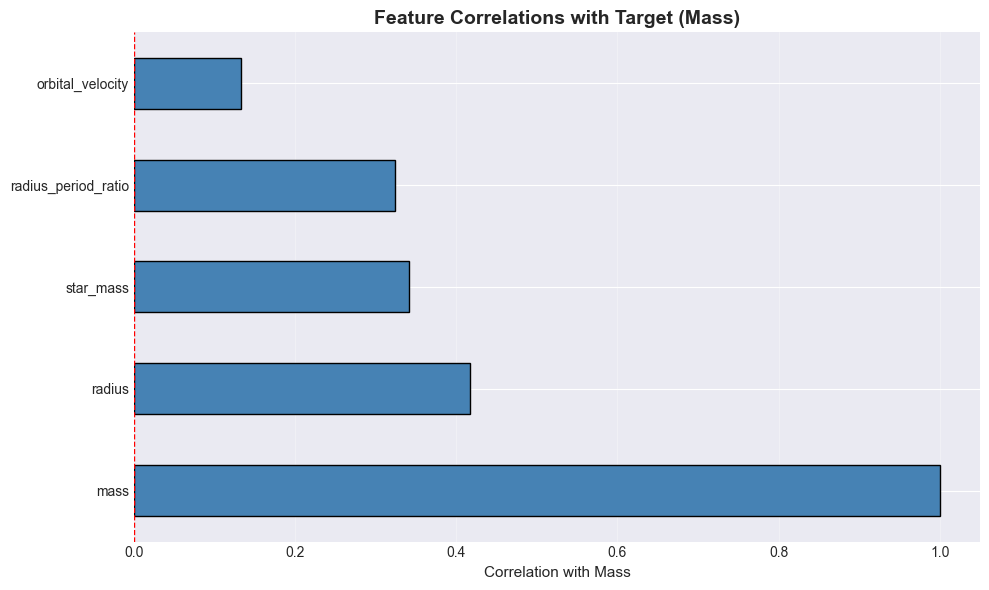


Figure saved: ../outputs/figures/v2_feature_correlations.png

Insights:
- Higher absolute correlation = stronger relationship with mass
- New features should add predictive power


In [7]:
print("="*80)
print("CORRELATION ANALYSIS - NEW FEATURES vs TARGET")
print("="*80)

correlations = df_engineered[engineered_features + ['mass']].corr()['mass'].sort_values(ascending=False)

print("\nCorrelation with mass (target):")
print(correlations.to_string())

fig, ax = plt.subplots(figsize=(10, 6))
correlations[:-1].plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Correlation with Mass', fontsize=11)
ax.set_title('Feature Correlations with Target (Mass)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/figures/v2_feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: ../outputs/figures/v2_feature_correlations.png")

print("\nInsights:")
print("- Higher absolute correlation = stronger relationship with mass")
print("- New features should add predictive power")

In [8]:
print("="*80)
print("TRAIN/TEST SPLIT - WITH ENGINEERED FEATURES")
print("="*80)

X = df_engineered[engineered_features]
y = df_engineered['mass']
y_log = np.log1p(y)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print(f"\nNumber of features: {X_train.shape[1]}")
print("Features used:")
for feat in engineered_features:
    print(f"  - {feat}")

TRAIN/TEST SPLIT - WITH ENGINEERED FEATURES

Training set: 1216 samples
Test set: 305 samples

Number of features: 5
Features used:
  - radius
  - orbital_period
  - star_mass
  - orbital_velocity
  - radius_period_ratio


In [9]:
print("="*80)
print("MODEL 1: LINEAR REGRESSION (WITH ENGINEERED FEATURES)")
print("="*80)

lr_original = LinearRegression()
lr_original.fit(X_train, y_train)

y_pred_lr_train = lr_original.predict(X_train)
y_pred_lr_test = lr_original.predict(X_test)

lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)
lr_test_mae = mean_absolute_error(y_test, y_pred_lr_test)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))

print("\nOriginal Scale Performance:")
print(f"  Train R2: {lr_train_r2:.4f}")
print(f"  Test R2:  {lr_test_r2:.4f}")
print(f"  Test MAE: {lr_test_mae:.4f}")
print(f"  Test RMSE: {lr_test_rmse:.4f}")

lr_log = LinearRegression()
lr_log.fit(X_train_log, y_train_log)

y_pred_lr_log_train = lr_log.predict(X_train_log)
y_pred_lr_log_test = lr_log.predict(X_test_log)

lr_log_train_r2 = r2_score(y_train_log, y_pred_lr_log_train)
lr_log_test_r2 = r2_score(y_test_log, y_pred_lr_log_test)

# Transform back to original scale
y_pred_back_train = np.expm1(y_pred_lr_log_train)
y_pred_back_test = np.expm1(y_pred_lr_log_test)

# Metrics on original scale (inverse transformed)
lr_back_train_r2 = r2_score(y_train, y_pred_back_train)
lr_back_test_r2 = r2_score(y_test, y_pred_back_test)
lr_back_test_mae = mean_absolute_error(y_test, y_pred_back_test)
lr_back_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_back_test))

print("\nLog Transform Performance (back-transformed):")
print(f"  Train R2: {lr_back_train_r2:.4f}")
print(f"  Test R2:  {lr_back_test_r2:.4f}")
print(f"  Test MAE: {lr_back_test_mae:.4f}")
print(f"  Test RMSE: {lr_back_test_rmse:.4f}")

print("\nComparison:")
print(f"  Baseline (3 features):           R2 = 0.0755")
print(f"  Log only (3 features):           R2 = 0.1124")
print(f"  Original + Engineered (5 feat):  R2 = {lr_test_r2:.4f}")
print(f"  Log + Engineered (5 feat):       R2 = {lr_back_test_r2:.4f}")

MODEL 1: LINEAR REGRESSION (WITH ENGINEERED FEATURES)

Original Scale Performance:
  Train R2: 0.2177
  Test R2:  0.0752
  Test MAE: 0.8020
  Test RMSE: 1.4067

Log Transform Performance (back-transformed):
  Train R2: 0.0041
  Test R2:  0.1085
  Test MAE: 0.6184
  Test RMSE: 1.3811

Comparison:
  Baseline (3 features):           R2 = 0.0755
  Log only (3 features):           R2 = 0.1124
  Original + Engineered (5 feat):  R2 = 0.0752
  Log + Engineered (5 feat):       R2 = 0.1085


In [10]:
print("="*80)
print("MODEL 2: RANDOM FOREST (WITH ENGINEERED FEATURES)")
print("="*80)

# Train on LOG scale with tuned parameters
rf_log = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_log.fit(X_train_log, y_train_log)

# Predict
y_pred_rf_log_train = rf_log.predict(X_train_log)
y_pred_rf_log_test = rf_log.predict(X_test_log)

# Metrics on log scale
rf_log_train_r2 = r2_score(y_train_log, y_pred_rf_log_train)
rf_log_test_r2 = r2_score(y_test_log, y_pred_rf_log_test)

# Transform back
y_pred_rf_back_train = np.expm1(y_pred_rf_log_train)
y_pred_rf_back_test = np.expm1(y_pred_rf_log_test)

# Metrics on original scale
rf_back_train_r2 = r2_score(y_train, y_pred_rf_back_train)
rf_back_test_r2 = r2_score(y_test, y_pred_rf_back_test)
rf_back_test_mae = mean_absolute_error(y_test, y_pred_rf_back_test)
rf_back_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_back_test))

print("\nRandom Forest Performance (back-transformed):")
print(f"  Train R2: {rf_back_train_r2:.4f}")
print(f"  Test R2:  {rf_back_test_r2:.4f}")
print(f"  Test MAE: {rf_back_test_mae:.4f}")
print(f"  Test RMSE: {rf_back_test_rmse:.4f}")

print("\nOverfitting Check:")
print(f"  Train R2 - Test R2 = {rf_log_train_r2 - rf_log_test_r2:.4f}")

print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': engineered_features,
    'importance': rf_log.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))

print("\nComparison:")
print(f"  RF Log only (3 features):        R2 = 0.1242")
print(f"  RF Log + Engineered (5 feat):    R2 = {rf_back_test_r2:.4f}")

MODEL 2: RANDOM FOREST (WITH ENGINEERED FEATURES)

Random Forest Performance (back-transformed):
  Train R2: 0.5589
  Test R2:  0.1105
  Test MAE: 0.5838
  Test RMSE: 1.3796

Overfitting Check:
  Train R2 - Test R2 = 0.4606

Feature Importance:
            feature  importance
             radius    0.663275
          star_mass    0.107149
   orbital_velocity    0.102539
radius_period_ratio    0.065206
     orbital_period    0.061830

Comparison:
  RF Log only (3 features):        R2 = 0.1242
  RF Log + Engineered (5 feat):    R2 = 0.1105


In [ ]:
print("="*80)
print("FEATURE ENGINEERING EXPERIMENT - CONCLUSION")
print("="*80)

comparison = pd.DataFrame({
    'Approach': [
        'Baseline (MVP)',
        'Log Transform',
        'Log + Feature Eng'
    ],
    'Features': [3, 3, 5],
    'Best_Model': [
        'Linear Regression',
        'Linear Regression',
        'Linear Regression'
    ],
    'Test_R2': [
        0.0755,
        0.1124,
        lr_back_test_r2
    ],
    'Improvement_vs_Baseline': [
        '1.0x',
        '1.5x',
        f'{lr_back_test_r2/0.0755:.1f}x'
    ]
})

print("\n", comparison.to_string(index=False))

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("\nWhat Worked:")
print("  - Log transform: modest improvement (1.5x)")

print("\nWhat Did NOT Work:")
print("  - New engineered features (orbital_velocity, radius_period_ratio)")
print("  - Feature importance shows radius dominates (66%)")
print("  - New features added minimal predictive power")

print("\nWhy Feature Engineering Failed:")
print("  1. Limited information: only orbital/stellar data available")
print("  2. Mass-radius relationship is complex (not linear)")
print("  3. Missing critical features (composition, atmosphere)")
print("  4. Inherent difficulty: predicting mass from orbit alone")

print("\n" + "="*80)
print(f"BEST RESULT SO FAR: R2 = 0.1124 (Log transform only)")
print("="*80)

FEATURE ENGINEERING EXPERIMENT - CONCLUSION

          Approach  Features        Best_Model  Test_R2 Improvement_vs_Baseline
   Baseline (MVP)         3 Linear Regression 0.075500                    1.0x
    Log Transform         3 Linear Regression 0.112400                    1.5x
Log + Feature Eng         5 Linear Regression 0.108497                    1.4x

KEY FINDINGS

What Worked:
  - Log transform: modest improvement (1.5x)

What Did NOT Work:
  - New engineered features (orbital_velocity, radius_period_ratio)
  - Feature importance shows radius dominates (66%)
  - New features added minimal predictive power

Why Feature Engineering Failed:
  1. Limited information: only orbital/stellar data available
  2. Mass-radius relationship is complex (not linear)
  3. Missing critical features (composition, atmosphere)
  4. Inherent difficulty: predicting mass from orbit alone

Next Steps:
  - Try different models (Ridge, Lasso, XGBoost)
  - Polynomial features
  - Accept limitation: Sta